In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

pd.set_option('display.max_rows', 500)


In [2]:
# Import all data within date range (2020-01-01 to 2020-06-30)
conv_unfil = pd.read_csv('./data/conventional_unfiltered_2020.csv')
conv_unfil["text"] = conv_unfil["title"].fillna('') + " " + conv_unfil["excerpt"].fillna('')
conv_unfil = conv_unfil[['date_time', 'text', 'entity']]
conv_unfil['date'] = pd.to_datetime(conv_unfil.date_time, format= '%Y-%m-%d %H:%M:%S')
conv_unfil['date'] = conv_unfil['date'].dt.date

cryp_unfil = pd.read_csv('./data/crypto_2020_unfiltered_updated.csv')
cryp_unfil["text"] = cryp_unfil["title"].fillna('') + " " + cryp_unfil["excerpt"].fillna('')
cryp_unfil = cryp_unfil[['date_time', 'text', 'entity']]
cryp_unfil['date'] = pd.to_datetime(cryp_unfil.date_time, format= '%d/%m/%y %H:%M')
cryp_unfil['date'] = cryp_unfil['date'].dt.date

reddit_unfil = pd.read_csv('./data/reddit_unfiltered_2020.csv')
reddit_unfil["text"] = reddit_unfil["title"].fillna('') + " " + reddit_unfil["excerpt"].fillna('')
reddit_unfil = reddit_unfil[['date_time', 'text', 'entity']]
reddit_unfil['date'] = pd.to_datetime(reddit_unfil.date_time, format= '%Y-%m-%d %H:%M:%S')
reddit_unfil['date'] = reddit_unfil['date'].dt.date

twitter_unfil = pd.read_csv('./data/twitter_unfiltered_2020.csv')
twitter_unfil = twitter_unfil.rename(columns={"date": "date_time", "tweet":"text"})
twitter_unfil = twitter_unfil[['date_time', 'text', 'entity']]
twitter_unfil['date'] = pd.to_datetime(twitter_unfil.date_time, format= '%Y-%m-%d')
twitter_unfil['date'] = twitter_unfil['date'].dt.date


all_unfil = conv_unfil.append(cryp_unfil)
all_unfil = all_unfil.append(reddit_unfil)
all_unfil = all_unfil.append(twitter_unfil)

all_unfil['entity'] = all_unfil['entity'].str.lower()


## Predicted high risk over time

Graph of hacks over time plots proportion of posts/articles predicted as high-risk relative to the total number of posts over time


In [3]:
#start_date/end_date in format: 'yyyy-mm-dd'

def perc_hack_graph(df, all_test, start_date, end_date, entity= '', vol = False):  
    # Process dataframe
    # Get datetime format for df date
    for fmt in ('%Y-%m-%d %H:%M:%S', '%d/%m/%y %H:%M', '%d/%m/%y'):
        try:
            df['date'] = pd.to_datetime(df.date_time, format=fmt)
        except ValueError:
            pass

    df['date'] = df['date'].dt.date
    df['entity'] = df['entity'].str.lower()
    
    #If there is an input in the entity, filter to retrieve only from entity    
    if entity != '':
        entity = entity.lower()
        
        #Get subset of dataframe with entity 
        df = df[df['entity'] == entity]
        tem1 = all_test[all_test['entity'] == entity]
    
    #Else if there is no entity restriction, use all the data
    else:
        tem1 = all_test
        
    
    #Group data by date and find the number of posts predicted as risky 
    df2 =  df.groupby('date').sum()
    
    #Get all date within range and fill dates with no data with 0 
    idx = pd.date_range(start_date, end_date)
    df2.index =  pd.DatetimeIndex(df2.index)
    df2 = df2.reindex(idx, fill_value=0)
        
    
    # Group data by date and find the number of posts on the date 
    tem1 =  tem1.groupby('date').count()
    
    # Get all date within range and fill dates with no data with 0 
    tem1.index = pd.DatetimeIndex(tem1.index)
    tem1 = tem1.reindex(idx, fill_value=0)
    
    # Merge  the 2 dataframes by date and calculate % risky
    df2['perc'] = df2['pred']/tem1['text'] * 100
    df2['perc'] = df2['perc'].fillna(0)

    #Print dates & percentage hack that values are exceptionally high (>95 percentile)
    
    high = df2['perc'].quantile(0.96)
    print(df2[df2['perc'] > high][['perc']])
    
    

    # Plot graph of % predicted risky over time 
    plt.figure(figsize=(15,10))
    plt.plot(df2.index, df2['perc'])
    plt.grid(True)
    plt.xlim()
    plt.xlabel('Date')
    plt.ylabel('% Predicted as high risk')
    plt.title('% Predicted as high risk over Time (' + entity + ')')
    plt.show()
    

In [4]:
def get_data_on_date(df, date, entity = ''):
    df2 = df[df['date'] == date]
    if entity != '':
        df2 = df2[df2['entity'] == entity]
    return df2

In [5]:
#Example Usage
#data = get_data_on_date(df, datetime(2020,2,1).date())
#view = data[data['pred']==1]
#view

# Word2Vec

In [25]:
# Import all data within date range (2019-05-15 to 2019-12-31)

# Test data
df1 = pd.read_csv('./data/word2vec/2020_word2vec_reddit.csv')
df1["text"] = df1["title"].fillna('') + " " + df1["excerpt"].fillna('')
df1 = df1.rename(columns={"predict":"pred"})
df1 = df1[['date_time', 'text', 'pred', 'entity']]

df2 = pd.read_csv('./data/word2vec/2020_word2vec_conventional.csv')
df2["text"] = df2["title"].fillna('') + " " + df2["excerpt"].fillna('')
df2 = df2.rename(columns={"predict":"pred"})
df2 = df2[['date_time', 'text', 'pred', 'entity']]

df3 = pd.read_csv('./data/word2vec/2020_word2vec_crypto.csv')
df3["text"] = df3["title"].fillna('') + " " + df3["excerpt"].fillna('')
df3 = df3.rename(columns={"predict":"pred"})
df3 = df3[['date_time', 'text', 'pred', 'entity']]

df4 = pd.read_csv('./data/word2vec/2020_word2vec_twitter.csv')
df4 = df4.rename(columns={"date": "date_time", "tweet":"text","predict":"pred"})
df4 = df4[['date_time', 'text', 'pred', 'entity']]

df_w2v = df1.append(df2)
df_w2v = df_w2v.append(df3)
df_w2v = df_w2v.append(df4)

for fmt in ('%Y-%m-%d %H:%M:%S', '%d/%m/%y %H:%M', '%d/%m/%y'):
    try:
        df_w2v['date'] = pd.to_datetime(df_w2v.date_time, format=fmt)
    except ValueError:
        pass
    
df_w2v['date'] = df_w2v['date'].dt.date
df_w2v['entity'] = df_w2v['entity'].str.lower()



In [26]:
df_w2v.head()

,date_time,text,pred,entity,date
0,2020-06-29 11:16:37,balancer just got hacked it seems https://medi...,1,1inch.exchange,2020-06-29
1,2020-06-29 10:58:19,another article.\n\nhttps://medium.com/@1inch....,0,1inch.exchange,2020-06-29
2,2020-06-18 18:39:28,revoke your permissions and contracts? honestl...,0,1inch.exchange,2020-06-18
3,2020-02-25 03:27:22,"no uniswap, no synthetix, 3 lending services -...",0,1inch.exchange,2020-02-25
4,2020-02-21 08:19:25,https://medium.com/@1inch.exchange/yes-we-hack...,0,1inch.exchange,2020-02-21


                 perc
2020-01-10   2.197802
2020-02-01   2.637363
2020-02-11   1.225115
2020-02-28   1.463415
2020-02-29   1.355932
2020-04-09   1.650619
2020-05-13  17.824561
2020-06-12   1.264489


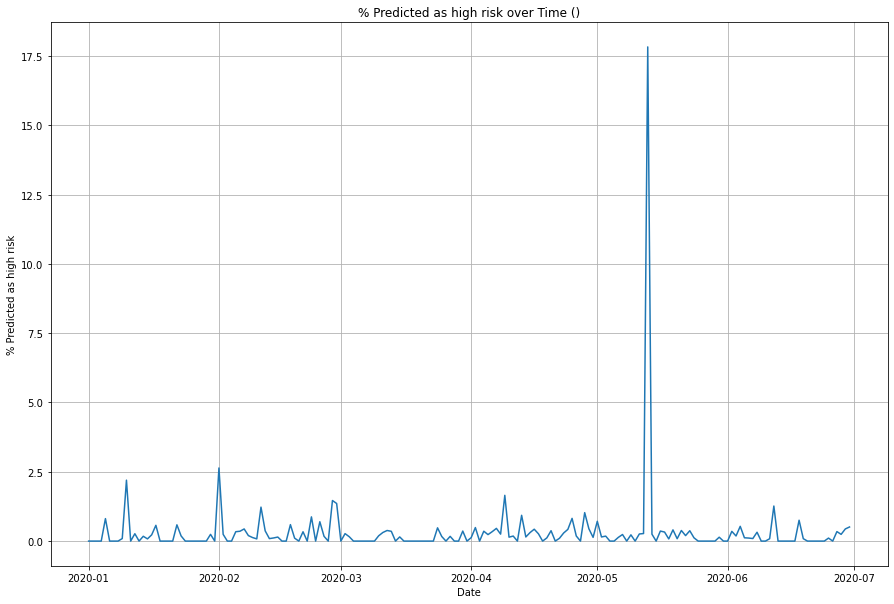

In [27]:
#Word2Vec (SVM)
perc_hack_graph(df_w2v, all_unfil, '2020-01-01', '2020-06-30')


2020-01-10 - exit scam: shutdown notice by cobinhood exchange	

2020-02-01 - trezor wallets can be hacked, kraken reveals	(identified under Kraken (wrong entity))

2020-02-11 - altsbit crypto exchange to shut down following hack

2020-02-28 - Okex, bitfinex ddos attack 

2020-02-29 - Okex, bitfinex ddos attack 

2020-04-09 - binance denies that it stole $1 million from o...	

2020-05-13 - Upbit fund movement causing false +ve

2020-06-12  - Bitfinex Hackers Move Another $4.1 Million Bitcoin in Their Biggest Pay Day Yet false +ve





### By entity

##### Uniswap

                perc
2020-04-20  8.333333
2020-04-22  4.545455


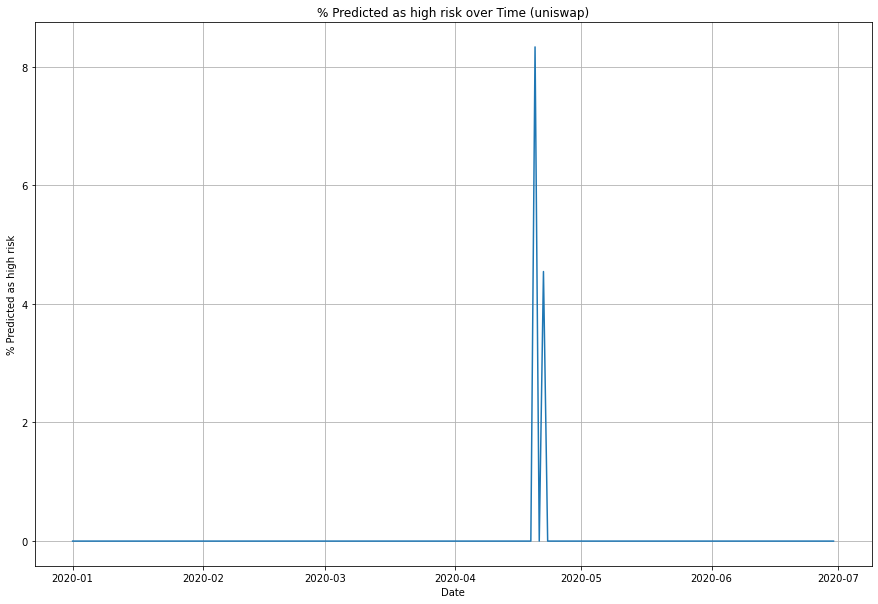

In [28]:
perc_hack_graph(df_w2v, all_unfil, '2020-01-01', '2020-06-30', 'uniswap')


2020-04-20: Uniswap hack


##### Balancer

                perc
2020-06-29  3.773585


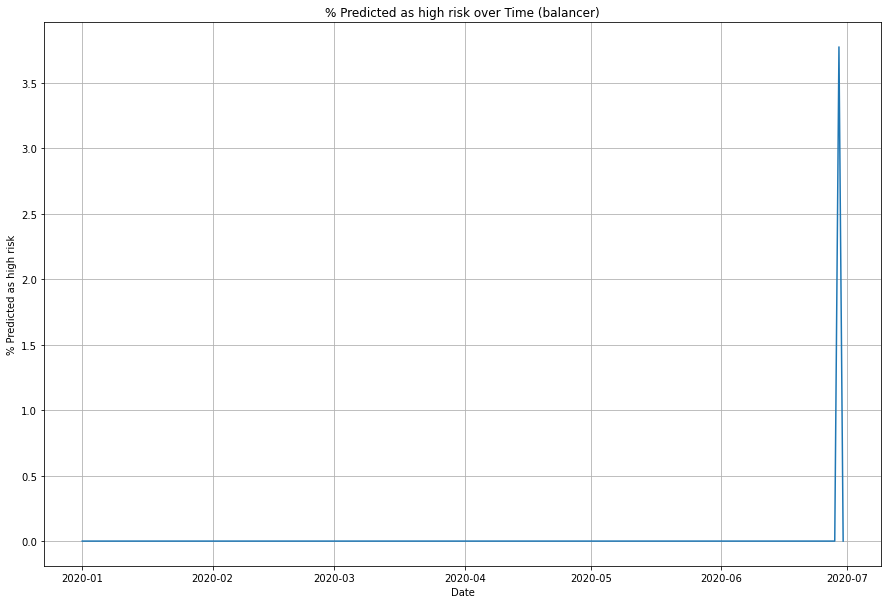

In [35]:
perc_hack_graph(df_w2v, all_unfil, '2020-01-01', '2020-06-30', 'balancer')


2020-06-29 - balancer hack


##### Altsbit

                  perc
2020-02-07   33.333333
2020-02-10   50.000000
2020-02-11  100.000000


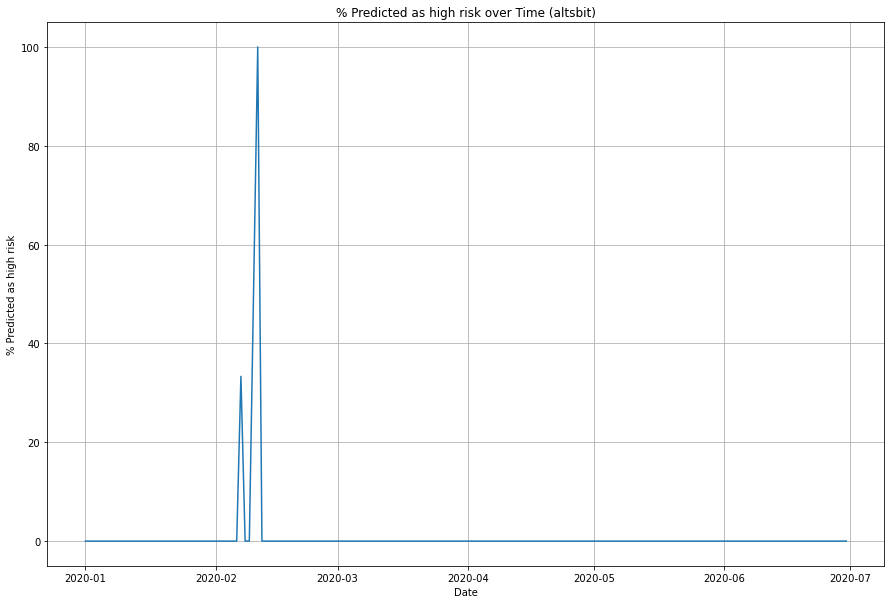

In [37]:
perc_hack_graph(df_w2v, all_unfil, '2020-01-01', '2020-06-30', 'altsbit')


2020-02-06 - Altsbit hack 

2020-02-10 - Altsbit hack leading to its shutdown

##### Coincheck

                  perc
2020-03-12   66.666667
2020-03-13   75.000000
2020-03-15  100.000000
2020-04-02  100.000000
2020-06-04   50.000000
2020-06-08  100.000000


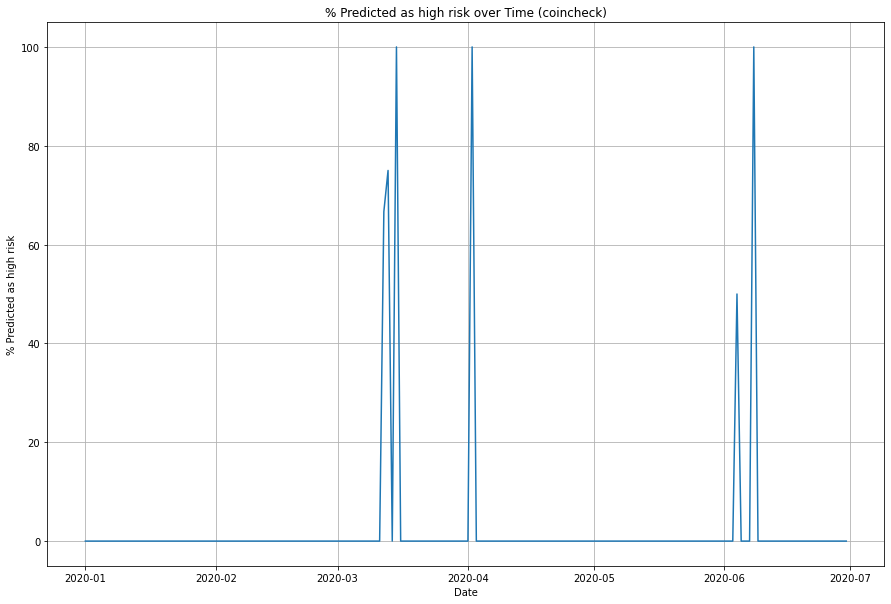

In [39]:
perc_hack_graph(df_w2v, all_unfil, '2020-01-01', '2020-06-30', 'coincheck')


2020-03-12  - Past hack: arrest of hackers

2020-03-13 - Past hack: police reveal details about coincheck hack suspects 

2020-03-15  - Past hack: Stolen NEM From Coincheck in 2018 is Still Available...	)

2020-04-02  - Past hack: prosecutors charge two men over coincheck hack...	

2020-06-04  - Data breach

2020-06-08  - Posts related to above



##### Fcoin

                  perc
2020-02-18   31.250000
2020-02-19   11.111111
2020-02-21  100.000000
2020-02-23   80.000000
2020-02-25   50.000000
2020-06-12   50.000000


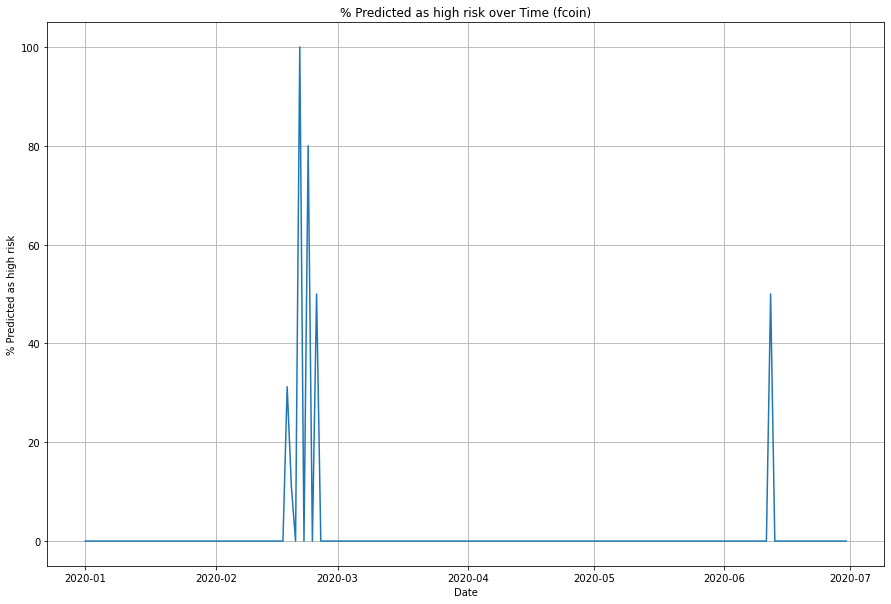

In [44]:
perc_hack_graph(df_w2v, all_unfil, '2020-01-01', '2020-06-30', 'fcoin')


2020-02-18: fcoin shuts down; owes users around $125 million 

2020-06-12: Past article related to above shut down

##### Bitfinex

                 perc
2020-02-28  24.242424
2020-02-29  12.500000
2020-03-30   7.142857
2020-05-22  10.526316
2020-05-23  12.000000
2020-06-02  11.111111
2020-06-04  11.111111
2020-06-12  26.666667


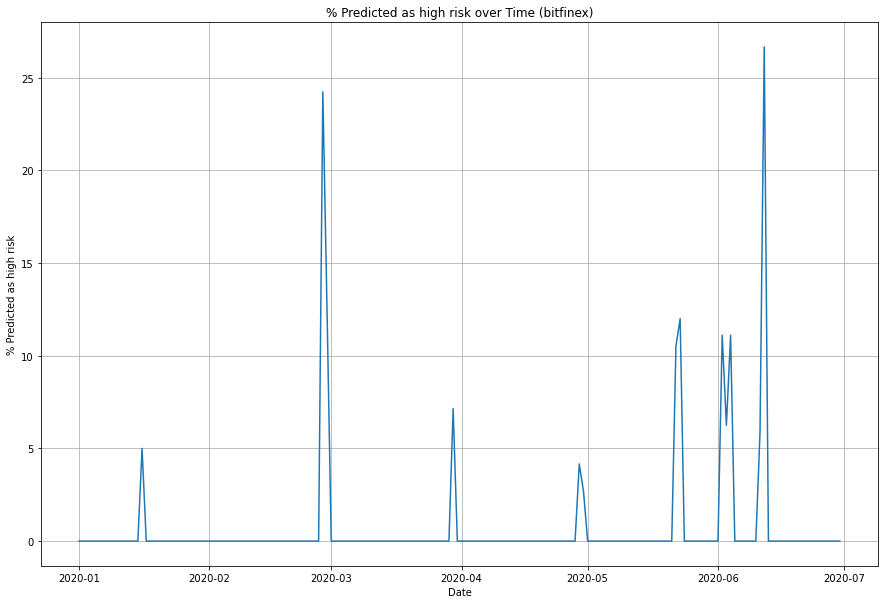

In [45]:
perc_hack_graph(df_w2v, all_unfil, '2020-01-01', '2020-06-30','bitfinex')


2020-02-28 - bitfinex hit by ddos attack

2020-02-29 - related articles to above ddos

2020-03-30 - False +ve (Bitfinex DeFi Offshoot Burns $20M Tokens in Bi..)

2020-05-22 - Past hack: bitfinex hackers move $275,000 from 2016 hack	

2020-05-23 - Past hack: bitfinex fund movement

2020-06-02 -  Past hack: bitfinex fund movement

2020-06-04 - False +ve 

2020-06-12 -  Past hack: bitfinex fund movemen

##### Binance

                perc
2020-02-25  2.777778
2020-03-10  1.562500
2020-04-07  2.830189
2020-04-09  6.756757
2020-04-16  4.166667
2020-04-23  2.298851
2020-04-24  2.000000
2020-05-01  3.821656


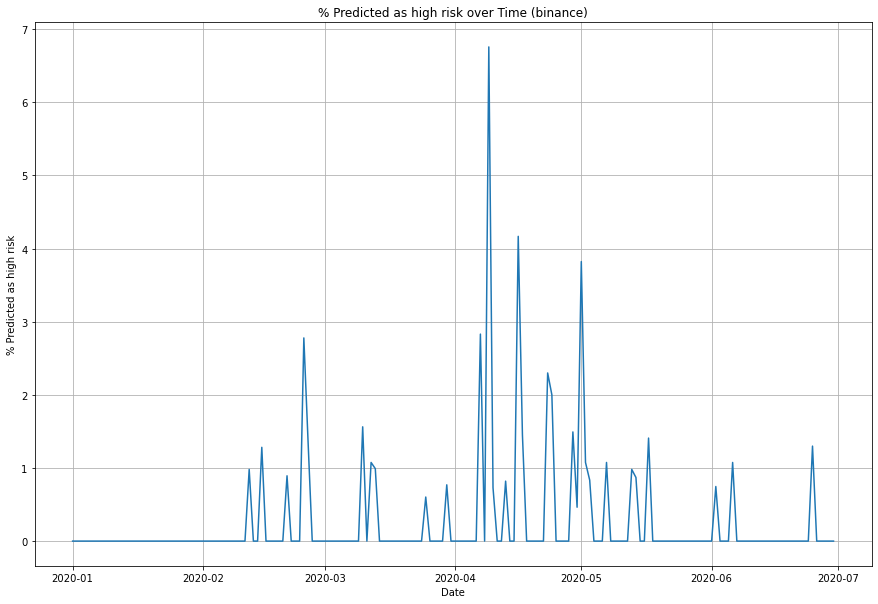

In [52]:
perc_hack_graph(df_w2v, all_unfil, '2020-01-01', '2020-06-30','binance')


2020-01-12 - false +ve (only 1 labelled high risk)

2020-01-18 - false +ve? (Bitcoin fund manager has Binance account hacked)

2020-03-11 - Binance Users in Turkey May Have Been Compromised, Many Receive Phishing SMS Messages

2020-04-07 - Binance Accused of Stealing $1 Million Worth of Assets: Company Denies Everything but Class Action Underway

2020-04-09 - False +ve (Statement by Binance: Binance denies theft of 3.995 Ethereum and 429...	)

2020-04-10 - False +ve (Statement by Binance: Binance denies theft...	)

2020-04-16 - Subjective comments on reddit 

2020-04-29 - Binance ddos attack


2020-02-25 - binance ceo calls craig wright a fraud 

2020-03-10  - false +ve

2020-04-07 - binance accused of stealing $1 million worth o...	

2020-04-09 - Binance denies theft of 3.995 Ethereum and 429...	

2020-04-16 - binance accused of stealing $1 million worth o...	

2020-04-23 - binance notifies crypto users of new ios secur...	

2020-04-24 - binance notifies crypto users of new ios secur...	

2020-05-01 - binance confirmed the security breach news	

*did not capture ddos attack on 2020-04-29

##### Bancor

                 perc
2020-06-18  17.021277
2020-06-19   4.000000


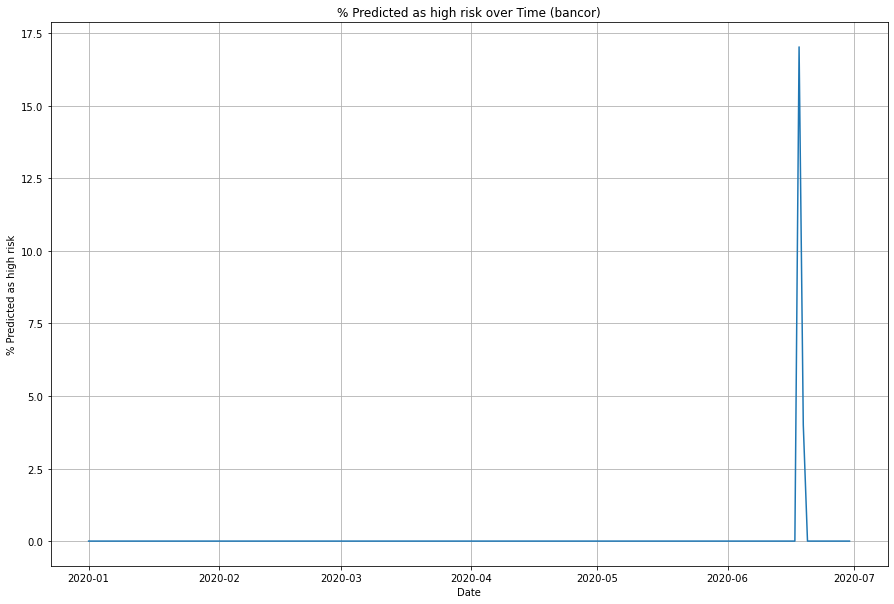

In [64]:
perc_hack_graph(df_w2v, all_unfil, '2020-01-01', '2020-06-30','bancor')


2020-06-18 - bancor discovers critical vulnerability, hacks itself to prevent theft

2020-06-19 - ^


##### Blockfi

                perc
2020-05-19  7.142857
2020-05-20  0.917431
2020-05-21  0.643087
2020-06-04  2.083333


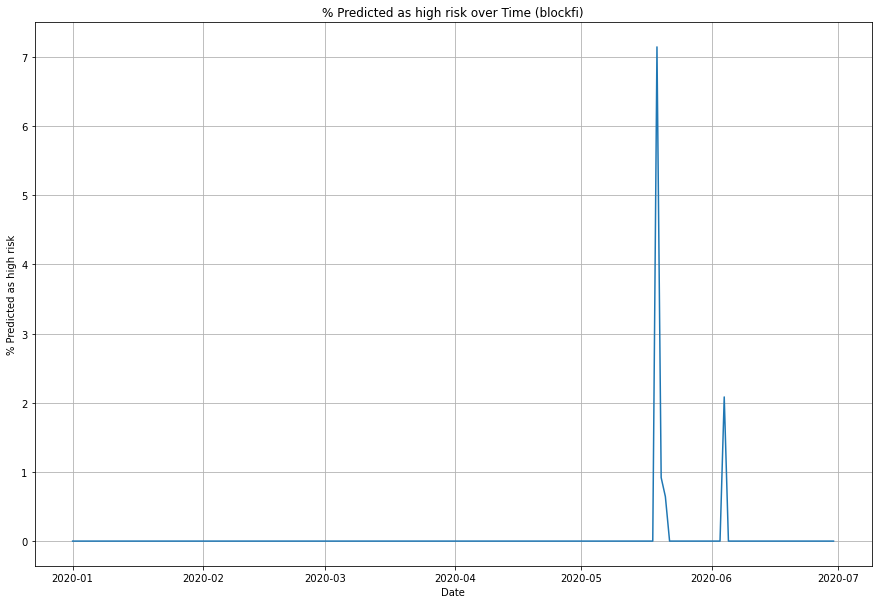

In [62]:
perc_hack_graph(df_w2v, all_unfil, '2020-01-01', '2020-06-30','blockfi')


2020-05-19 - blockfi attacked, attacker had access to private data

2020-05-20 - ^

2020-05-21 - ^

Other dates with smaller peaks: (1 comment on social media being captured as high risk)